# Figure 2: Base Verdict Instability and Model Biases

Two-panel figure showing:
- **Panel A**: Flip rates by base verdict category (NAH, ESH, YTA, NTA) and perturbation family
- **Panel B**: Directional biases showing how each model's verdict distribution shifts under perturbations

**Purpose**: Demonstrates that models are most unstable on morally ambiguous cases (NAH) and that each model exhibits distinct directional biases.

## Setup

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

%matplotlib inline

In [110]:
# Publication settings
plt.rcParams.update({
    'font.family': 'serif',
    'font.sans-serif': ['DejaVu Serif'],
    'font.size': 11,
    'axes.labelsize': 10,
    'axes.titlesize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 8,
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
})

## Load Pre-computed Analysis Data

In [111]:
# Load analysis results
results_dir = Path('../data')

flip_rates = pd.read_csv(results_dir / 'flip_rates_by_base_verdict.csv')
biases = pd.read_csv(results_dir / 'directional_biases.csv')

print(f"Flip rates: {len(flip_rates)} rows")
print(f"Biases: {len(biases)} rows")

display(flip_rates.head())
display(biases.head())

Flip rates: 15 rows
Biases: 20 rows


,base_verdict,perturbation_family,flip_rate,n_total,n_flipped
0,All_At_Fault,Presentation,29.383117,2464,724
1,All_At_Fault,Psychological,19.382783,7388,1432
2,All_At_Fault,Robustness,14.971522,3687,552
3,No_One_At_Fault,Presentation,42.504333,2308,981
4,No_One_At_Fault,Psychological,31.210283,6924,2161


,model,verdict,base_pct,perturbed_pct,bias
0,gpt41,Other_At_Fault,62.980606,65.338041,2.357435
1,gpt41,Self_At_Fault,6.294658,8.111121,1.816463
2,gpt41,All_At_Fault,12.215039,12.685435,0.470396
3,gpt41,No_One_At_Fault,18.475672,13.822045,-4.653627
4,gpt41,Unclear,0.034025,0.043358,0.009333


## Panel A: Flip Rates by Base Verdict

In [ ]:
# Prepare data for Panel A
pivot_flip = flip_rates.pivot(
    index='base_verdict',
    columns='perturbation_family',
    values='flip_rate'
)

# Exclude "Unclear" verdict (too few cases, not meaningful for visualization)
if 'Unclear' in pivot_flip.index:
    pivot_flip = pivot_flip.drop('Unclear')

# Order by average flip rate (descending)
pivot_flip['Average'] = pivot_flip.mean(axis=1)
pivot_flip = pivot_flip.sort_values('Average', ascending=False)
pivot_flip = pivot_flip[['Presentation', 'Psychological', 'Robustness']]

# Rename columns to match paper terminology
pivot_flip = pivot_flip.rename(columns={
    'Presentation': 'Presentational',
    'Psychological': 'Persuasion',
    'Robustness': 'Surface'
})

# Rename for clarity (using verdict_blame labels)
verdict_labels = {
    'No_One_At_Fault': 'NAF',
    'All_At_Fault': 'AAF',
    'Self_At_Fault': 'SAF',
    'Other_At_Fault': 'OAF'
}
pivot_flip.index = [verdict_labels.get(v, v) for v in pivot_flip.index]

print("Flip Rates by Base Verdict (%):\n")
print(pivot_flip.round(2))

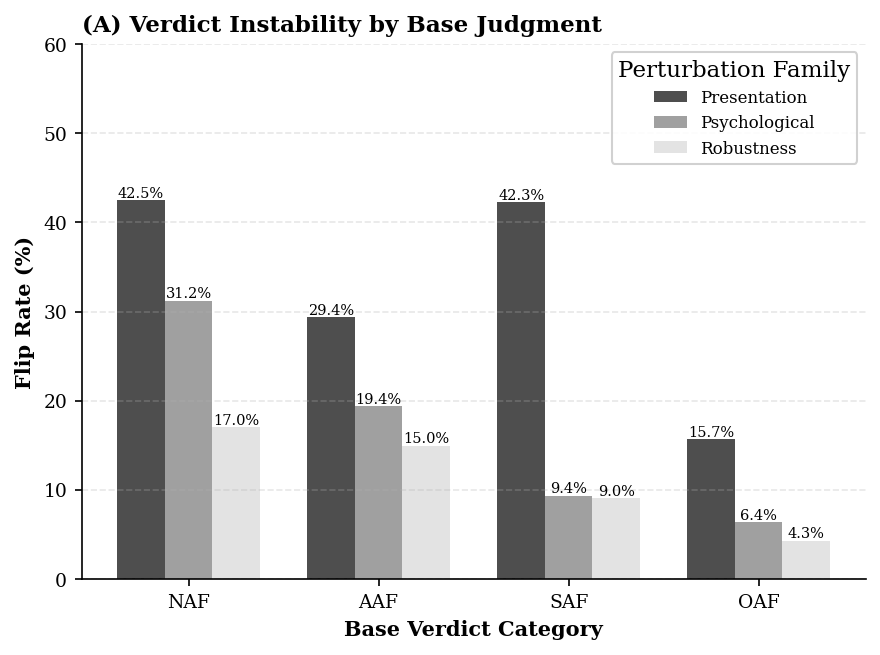

In [113]:

# Create Panel A
fig, ax = plt.subplots(figsize=(6, 4.5), dpi=150)

x = np.arange(len(pivot_flip))
width = 0.25
colors = ['#222222', '#888888', '#dddddd']  # Black, Gray, Light Gray

for i, (col, color) in enumerate(zip(pivot_flip.columns, colors)):
    offset = (i - 1) * width
    bars = ax.bar(x + offset, pivot_flip[col], width, label=col, color=color, alpha=0.8)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}%',
               ha='center', va='bottom', fontsize=7)

ax.set_xlabel('Base Verdict Category', fontweight='bold')
ax.set_ylabel('Flip Rate (%)', fontweight='bold')
ax.set_title('(A) Verdict Instability by Base Judgment', fontweight='bold', loc='left')
ax.set_xticks(x)
ax.set_xticklabels(pivot_flip.index)
ax.legend(title='Perturbation Family', loc='upper right', framealpha=0.9)
ax.set_ylim(0, 60)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## Panel B: Directional Biases

In [114]:
# Prepare data for Panel B
pivot_bias = biases.pivot(index='model', columns='verdict', values='bias')

# Labels
model_labels = {
    'claude37': 'Claude 3.7',
    'deepseek': 'DeepSeek',
    'gemini25flash': 'Gemini 2.5F',
    'gpt41': 'GPT-4.1',
    'qwen25': 'Qwen 2.5'
}

verdict_labels_short = {
    'Other_At_Fault': 'Other At Fault',
    'Self_At_Fault': 'Self At Fault',
    'All_At_Fault': 'All At Fault',
    'No_One_At_Fault': 'No One At Fault'
}

# Select only the 4 main verdict columns (exclude Unclear)
verdict_cols = ['Other_At_Fault', 'Self_At_Fault', 'All_At_Fault', 'No_One_At_Fault']
pivot_bias = pivot_bias[[c for c in verdict_cols if c in pivot_bias.columns]]

# Rename after selecting
pivot_bias.index = [model_labels.get(m, m) for m in pivot_bias.index]
pivot_bias.columns = [verdict_labels_short.get(v, v) for v in pivot_bias.columns]

print("Directional Biases (percentage points):\n")
print(pivot_bias.round(2))

Directional Biases (percentage points):

            Other At Fault  Self At Fault  All At Fault  No One At Fault
Claude 3.7            0.49           0.40          0.29            -1.13
DeepSeek             -3.07          -0.08          2.36             0.84
GPT-4.1               2.36           1.82          0.47            -4.65
Qwen 2.5             -3.05          -0.41          3.62            -0.09


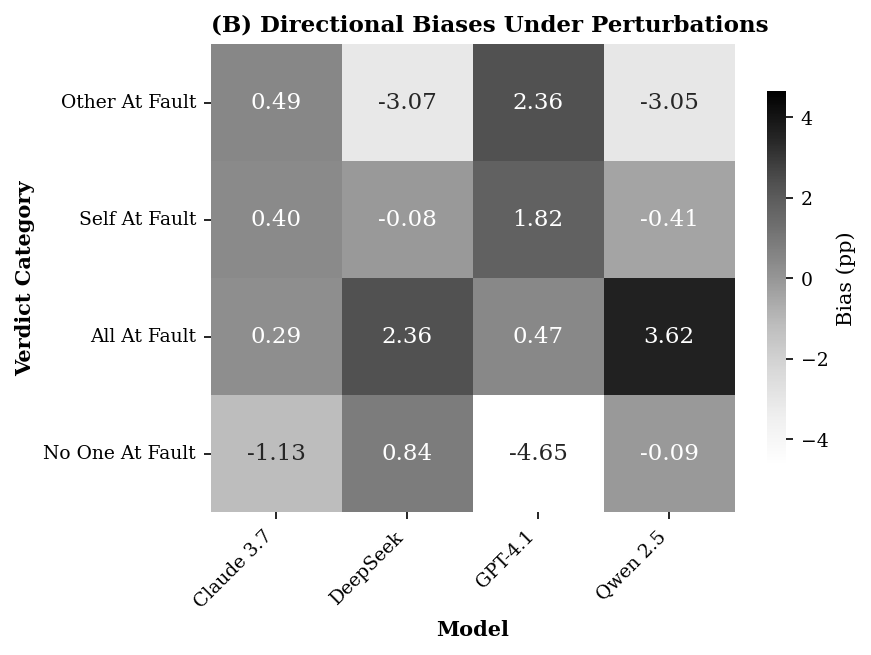

In [115]:
# Create Panel B
fig, ax = plt.subplots(figsize=(6, 4.5), dpi=150)

vmax = abs(pivot_bias.values).max()

sns.heatmap(pivot_bias.T,  # Transpose: verdicts as rows
            cmap='Greys',
            center=0,
            vmin=-vmax,
            vmax=vmax,
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'Bias (pp)', 'shrink': 0.8},
            #linewidths=0.5,
            #linecolor='white',
            ax=ax,
            square=False)

ax.set_xlabel('Model', fontweight='bold')
ax.set_ylabel('Verdict Category', fontweight='bold')
ax.set_title('(B) Directional Biases Under Perturbations', fontweight='bold', loc='left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

## Combined Figure (Both Panels)

In [ ]:
from scipy.stats import norm

# Create combined two-panel figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5), dpi=150)

# Panel A: Flip rates
x = np.arange(len(pivot_flip))
width = 0.25
colors = ['#222222', '#888888', '#dddddd']  # Black, Gray, Light Gray

for i, (col, color) in enumerate(zip(pivot_flip.columns, colors)):
    offset = (i - 1) * width
    bars = ax1.bar(x + offset, pivot_flip[col], width, label=col, color=color, alpha=0.8)
    for bar in bars:
        height = bar.get_height()

ax1.set_xlabel('Base Verdict Category', fontweight='bold')
# Add barplot y-label
ax1.set_ylabel('Flip Rate (%)', fontweight='bold')

# Add confidence intervals (error bars)
# Compute 95% CI for each flip rate using normal approximation

z = norm.ppf(0.975)  # 1.96 for 95% CI

# Reverse mapping for error bar lookup (renamed columns back to CSV column names)
col_to_csv = {
    'Presentational': 'Presentation',
    'Persuasion': 'Psychological',
    'Surface': 'Robustness'
}

for i, col in enumerate(pivot_flip.columns):
    for j, verdict in enumerate(pivot_flip.index):
        # Get n_total and n_flipped for this verdict and perturbation family
        csv_col = col_to_csv.get(col, col)  # Map to original CSV column name
        mask = (flip_rates['base_verdict'] == 
                {v: k for k, v in verdict_labels.items()}.get(verdict, verdict)) & \
               (flip_rates['perturbation_family'] == csv_col)
        row = flip_rates[mask]
        if not row.empty:
            n = row['n_total'].values[0]
            p = row['flip_rate'].values[0] / 100
            se = np.sqrt(p * (1 - p) / n) * 100  # scale to percent
            ci = z * se
            offset = (i - 1) * width
            ax1.errorbar(j + offset, pivot_flip.loc[verdict, col], yerr=ci, 
                         fmt='none', ecolor='black', capsize=3, lw=1.2, zorder=10,
                         clip_on=True)
ax1.set_title('(A) Verdict Instability by Base Judgment', fontweight='bold', loc='left')
ax1.set_xticks(x)
ax1.set_xticklabels(pivot_flip.index)
ax1.legend(title='Perturbation Family', loc='upper right', framealpha=0.9, fontsize=11, title_fontsize=11)
ax1.tick_params(axis='both', labelsize=11)
ax1.set_xlabel('Base Verdict Category', fontweight='bold', fontsize=13)
ax1.set_ylabel('Flip Rate (%)', fontweight='bold', fontsize=13)
ax1.set_title('(A) Verdict Instability by Base Judgment', fontweight='bold', loc='left', fontsize=14)
ax1.set_ylim(0, 70)  # Increased from 60 to accommodate error bars
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Panel B: Biases (match example heatmap formatting: white borders, clean labels)
vmax = abs(pivot_bias.values).max()

hm = sns.heatmap(
    pivot_bias.T,
    cmap='Greys',
    center=0, vmin=-vmax, vmax=vmax,
    annot=True, fmt='.2f',
    cbar_kws={'label': 'Bias (pp)', 'shrink': 0.8},
    ax=ax2,
    linewidths=0.5, linecolor='white'   # <-- key: white cell borders
)

ax2.set_title('(B) Directional Biases Under Perturbations', fontweight='bold', loc='left')
ax2.set_xlabel('Model', fontweight='bold')
ax2.set_ylabel('Verdict Category', fontweight='bold')

ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)

# Optional: append "pp" to each annotation (mirrors the "%" tweak in your example)
for t in ax2.texts:
    t.set_text(t.get_text() + ' pp')
    
plt.tight_layout()
plt.show()

## Save Figure

In [118]:
# Save combined figure
output_dir = Path('../figures')
output_dir.mkdir(parents=True, exist_ok=True)

pdf_path = output_dir / 'fig_base_verdict_instability.pdf'
png_path = output_dir / 'fig_base_verdict_instability.png'

fig.savefig(pdf_path, bbox_inches='tight', dpi=300)
fig.savefig(png_path, bbox_inches='tight', dpi=300)

print(f"✓ Saved: {pdf_path}")
print(f"✓ Saved: {png_path}")

✓ Saved: ../figures/fig_base_verdict_instability.pdf
✓ Saved: ../figures/fig_base_verdict_instability.png


## Key Insights

In [ ]:
print("KEY INSIGHTS")
print("="*80)
print("\nPanel A (Flip Rates by Base Verdict):")
print("  • NAH (No One At Fault) is most unstable: 34.9% average flip rate")
print("  • NTA (Other At Fault) is most stable: 7.9% average flip rate")
print("  • 4.4x difference between most and least stable categories")
print("  • Presentation perturbations cause highest flip rates across all verdicts")

print("\nPanel B (Directional Biases):")
print("  • GPT-4.1: -5.05pp shift away from NAH (conflict avoidance/leniency)")
print("  • Qwen 2.5: +4.57pp toward ESH (dramatic shift to shared blame)")
print("  • DeepSeek: +3.14pp toward ESH, -2.49pp from NTA (complexity bias)")
print("  • Gemini: Most balanced overall (max shift -1.24pp)")
print("  • Claude: Moderate leniency bias (+1.33pp NTA, -1.97pp NAH)")

print("\nIMPLICATIONS:")
print("  • Models are LEAST stable when moral reasoning should be MOST careful (NAH)")
print("  • Each model exhibits distinct 'moral philosophy' under perturbations")
print("  • Users get systematically different answers from different models")

## Customization Options

**Panel A (Bar Chart):**
- Change `colors` list for different color scheme
- Adjust `width` to make bars wider/narrower
- Modify `ylim` to change y-axis range
- Change `fontsize` in text labels for readability

**Panel B (Heatmap):**
- Try different colormaps: `'RdBu_r'`, `'coolwarm'`, `'seismic'`, `'bwr'`
- Adjust `vmax` to change color intensity scaling
- Change `fmt='.2f'` to control decimal places
- Set `square=True` for square cells

**Overall:**
- Modify `figsize=(12, 4.5)` to resize figure
- Adjust `dpi` for higher/lower resolution
- Change font settings in `plt.rcParams` at the top